### Imports


In [8]:
import datetime
import pandas as pd
import numpy as np
import sklearn
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import xgboost as xg
import matplotlib.pyplot as plt
import shutil
import requests
import math
import shap

### Load data


In [9]:
data = pd.read_csv('dataset/train.csv')

count = (data['beds'] == 0).sum()
data = data[data['beds'] != 0]
count = (data['beds'] == 0).sum()


msk = np.random.rand(len(data)) <= 0.8

### Process data and train model

In [10]:
data['host_since'] = data['host_since'].fillna('2017-01-22')
data['first_review'] = data['first_review'].fillna('2017-01-22')
data['last_review'] = data['last_review'].fillna('2017-01-22')
data.host_since = pd.to_datetime(data.host_since, format='%Y-%m-%d')
data['host_since_in_years'] = datetime.datetime.now() - data['host_since']
data['host_since_in_years'] = data['host_since_in_years'].apply(lambda x: x.days)
data['host_since_in_years'] = data['host_since_in_years'].apply(lambda x: x/365)
data.host_since_in_years = pd.to_numeric(data.host_since_in_years)
data = data.drop('host_since', axis=1)

# first_review
data.first_review = pd.to_datetime(data.first_review, format='%Y-%m-%d')
data['first_review_in_years'] = datetime.datetime.now() - data['first_review']
data['first_review_in_years'] = data['first_review_in_years'].apply(lambda x: x.days)
data['first_review_in_years'] = data['first_review_in_years'].apply(lambda x: x/365)
data.first_review_in_years = pd.to_numeric(data.first_review_in_years)
data = data.drop('first_review', axis=1)

# last_review
data.last_review = pd.to_datetime(data.last_review, format='%Y-%m-%d')
data['last_review_in_years'] = datetime.datetime.now() - data['last_review']
data['last_review_in_years'] = data['last_review_in_years'].apply(lambda x: x.days)
data['last_review_in_years'] = data['last_review_in_years'].apply(lambda x: x/365)
data.last_review_in_years = pd.to_numeric(data.last_review_in_years)
data = data.drop('last_review', axis=1)


          # The Golden Gate Bridge's
center = {'SF': {'lat':  37.8199286, 'long': -122.47825510000001},
          # The White House
          'DC': {'lat':  38.897957, 'long': -77.036560},
          # Hollywood Walk of Fame
          'LA': { 'lat': 34.101639, 'long': -118.333694},
          # Times Square
          'NYC': { 'lat': 40.758896, 'long': -73.985130},
          # Freedom Trail
         'Boston': { 'lat': 42.363153, 'long': -71.0547732},
          # Millennium Park
          'Chicago': { 'lat':  41.882702, 'long':  -87.619392}}
         


def lat_to_main_attraction(row):
    return center[row['city']]['lat']
def long_to_main_attraction(row):
    return center[row['city']]['long']
    # long = center[row['city']]['long']
    # return np.sqrt((lat-data['latitude'])*2+(long-data['longitude'])*2)

lat = data.apply(lambda row: lat_to_main_attraction(row), axis=1)
long = data.apply(lambda row: long_to_main_attraction(row), axis=1)

data['distance_to_main_attraction'] = np.sqrt((lat-data['latitude'])**2+(long-data['longitude'])**2)


train = data[msk]
test = data[~msk]


binary_variables = ['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']

categorical_variables = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city',
                         'neighbourhood', 'amenities']

numeric_variables = ['log_price', 'accommodates', 'bathrooms', 'host_response_rate',
                     'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds', 'host_since_in_years', 
                     'first_review_in_years', 'last_review_in_years', 'distance_to_main_attraction']  

column_to_drop = ['id', 'name', 'thumbnail_url', 'zipcode', 'description', 'latitude', 'longitude']

columns = {'binary_variables': binary_variables, 'categorical_variables': categorical_variables,
           'numeric_variables': numeric_variables, 'column_to_drop': column_to_drop, 'binned_variables': []}

for column in columns['column_to_drop']:
    train = train.drop(column, axis=1)
    test = test.drop(column, axis=1)

for column in columns['binary_variables']:
    train[column] = train[column].apply(lambda x: True if x == 'TRUE' or x == 't' else False)
    test[column] = test[column].apply(lambda x: True if x == 'TRUE' or x == 't' else False)
    
train['host_response_rate'] = train['host_response_rate'].str.rstrip('%').astype('float') / 100.0
test['host_response_rate'] = test['host_response_rate'].str.rstrip('%').astype('float') / 100.0

for column in columns['numeric_variables']:
    train[column] = train[column].astype(float)
    test[column] = test[column].astype(float)
    
null_columns = []
for column in columns['binary_variables'] + columns['categorical_variables'] + columns['numeric_variables']:
    if train[column].isnull().sum():
        null_columns.append(column)
    if test[column].isnull().sum():
        null_columns.append(column)
        
avg_bath_per_accomm = (train['bathrooms']/train['accommodates']).mean()

train['bathrooms'] = train['bathrooms'].fillna(train['accommodates']*avg_bath_per_accomm)
test['bathrooms'] = test['bathrooms'].fillna(test['accommodates']*avg_bath_per_accomm)
null_columns = list(filter(lambda x : x!='bathrooms', null_columns))


avg_bedrooms_per_accomm = (train['bedrooms']/train['accommodates']).mean()

train['bedrooms'] = train['bedrooms'].fillna(train['accommodates']*avg_bedrooms_per_accomm)
test['bedrooms'] = test['bedrooms'].fillna(test['accommodates']*avg_bedrooms_per_accomm)
null_columns = list(filter(lambda x : x!='bedrooms', null_columns))


avg_beds_per_accomm = (train['beds']/train['accommodates']).mean()

train['beds'] = train['beds'].fillna(train['accommodates']*avg_beds_per_accomm)
test['beds'] = test['beds'].fillna(test['accommodates']*avg_beds_per_accomm)
null_columns = list(filter(lambda x : x!='beds', null_columns))


train_with_most_frequent_values = train.copy()
test_with_most_frequent_values = test.copy()
for column in null_columns:
    val = train_with_most_frequent_values[column].value_counts().index[0]
    train_with_most_frequent_values[column] = train_with_most_frequent_values[column].fillna(val)
    test_with_most_frequent_values[column] = test_with_most_frequent_values[column].fillna(val)

train = train_with_most_frequent_values
test = test_with_most_frequent_values

train = train.reset_index()
test = test.reset_index()

def collect_amenities(data, columns_dict):
    chars_to_remove = '"{}'
    amenities_set = set()
    for line in data['amenities']:
        amenities = line.split(',')
        for obj in amenities:
            for char in chars_to_remove:
                obj = obj.replace(char, "")
            if "translation missing" not in obj and obj != '':
                amenities_set.add(obj)
    for amenity in amenities_set:
        columns_dict['binary_variables'].append(amenity)
    return list(amenities_set)


def create_amenities_array(amenities_list, data):
    amenities_array = []
    for index, row in data.iterrows():
        array = np.zeros(shape=(len(amenities_list)))
        row_amen = data['amenities'][index].split(',')
        for amen in row_amen:
            item = amen.replace('"', '').replace('}', '').replace('{', '')
            if item in amenities_list:
                res = amenities_list.index(item)
                array[res] = 1
        amenities_array.append(array.tolist())

    amenities_df = pd.DataFrame(amenities_array, columns=amenities_list)
    return amenities_df


# converting amenities column to binary columns and updating columns_dict
def create_amenities_cols(data, amenities_set):
    amenities_array = create_amenities_array(amenities_set, data)

    data = data.drop(['amenities'], axis=1)
    data = pd.concat([data, amenities_array], axis=1)

    return data

amenities_list = collect_amenities(train, columns)
train = create_amenities_cols(train, amenities_list)
test = create_amenities_cols(test, amenities_list)
columns['categorical_variables'].remove('amenities')

top_neighbourhoods = train['neighbourhood'].value_counts().head(50).keys()
for index, row in train.iterrows():
    if row['neighbourhood'] not in top_neighbourhoods:
        train.at[index,'neighbourhood'] = 'other'
for index, row in test.iterrows():
    if row['neighbourhood'] not in top_neighbourhoods:
        test.at[index,'neighbourhood'] = 'other'
        
# we leave the target feature as is
oh_train = train['log_price']
oh_test = test['log_price']

# now adding the one hot encoded data
for variable in columns['binned_variables']+columns['categorical_variables']:
    onehot_train_col = pd.get_dummies(train[variable], prefix=variable)
    oh_train = pd.concat([oh_train, onehot_train_col], axis=1)

    onehot_test_col = pd.get_dummies(test[variable], prefix=variable)
    oh_test = pd.concat([oh_test, onehot_test_col], axis=1)
    
for col in columns['binary_variables']:
    train[col] = train[col].replace(True, 1)
    train[col] =train[col].replace(False, 0)
    oh_train = pd.concat([oh_train, train[col]], axis=1)

    test[col] = test[col].replace(True, 1)
    test[col] = test[col].replace(False, 0)
    oh_test = pd.concat([oh_test, test[col]], axis=1)
    
for col in columns['numeric_variables']:
    if col != 'log_price':
        oh_train = pd.concat([oh_train, train[col]], axis=1)

        oh_test = pd.concat([oh_test, test[col]], axis=1)
        
add_to_test = list(set(oh_train.columns) - set(oh_test.columns))
add_to_train = list(set(oh_test.columns) - set(oh_train.columns))
for col in add_to_train:
    oh_train[col] = 0
for col in add_to_test:
    oh_test[col] = 0

oh_test = oh_test[oh_train.columns]

train_y = oh_train['log_price'].values
train_x = oh_train.drop('log_price', axis=1)
test_y = oh_test['log_price'].values
test_x = oh_test.drop('log_price', axis=1)


xgb_r = xg.XGBRegressor()
 

xgb_r.fit(train_x, train_y)
 

prediction_test = xgb_r.predict(test_x)

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.3f}".format(mean_absolute_error(test_y, prediction_test)))
print("Mean Squared Error (Σ(|y-pred|/y)/n):",
      "{:,.3f}".format(mean_squared_error(test_y, prediction_test)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.3f}".
      format(np.sqrt(mean_squared_error(test_y, prediction_test))))
print("r2 score:", "{:,.3f}".format(r2_score(test_y, prediction_test)))

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Mean Absolute Error (Σ|y-pred|/n): 0.282
Mean Squared Error (Σ(|y-pred|/y)/n): 0.151
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0.389
r2 score: 0.703


In [13]:
train_x['distance_to_main_attraction']

0        0.064295
1        0.066871
2        0.027740
3        0.177086
4        0.091545
           ...   
59167    0.013623
59168    0.067660
59169    0.067432
59170    0.025306
59171    0.368688
Name: distance_to_main_attraction, Length: 59172, dtype: float64

### Calculate residuals, max over estimated, max under estimated

In [14]:
residuals = test_y - prediction_test
max_over_estimated = abs(min(residuals))
max_under_estimated = max(residuals)
max_over_idx = list(residuals).index(min(residuals))
max_under_idx = list(residuals).index(max(residuals))
print("Max over estimated error (log price):", "{:,.0f}".format(max_over_estimated))
print("Max under estimated error (log price):", "{:,.0f}".format(max_under_estimated))

Max over estimated error (log price): 3
Max under estimated error (log price): 3


<AxesSubplot:>

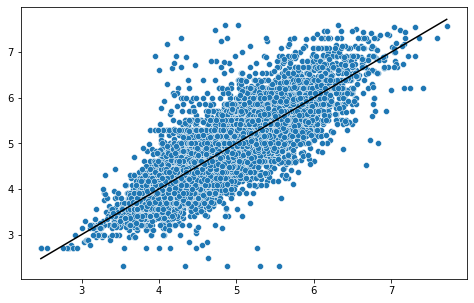

In [15]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x=prediction_test,y=test_y,ax=ax)
sns.lineplot(x=prediction_test,y=prediction_test,ax=ax,color='black')

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

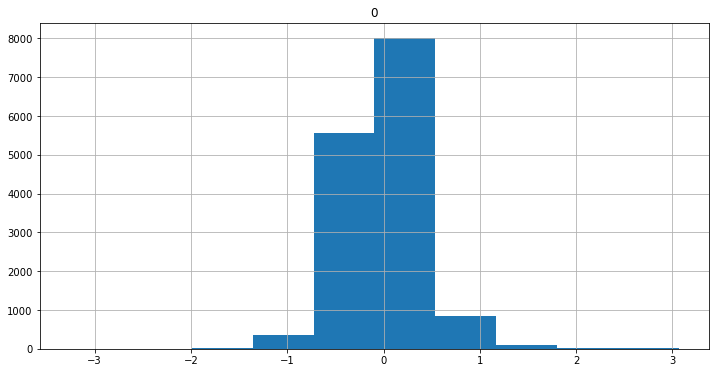

In [16]:
residuals_for_hist = pd.DataFrame(residuals)
residuals_for_hist.hist(figsize=(12,6))

### Calculate relative residuals

In [17]:
rel_res=residuals/test_y
rel_res=abs(rel_res)

In [18]:
len(rel_res[rel_res<0.05])/len(rel_res)

0.5419484432541011

In [19]:
len(rel_res[rel_res<0.1])/len(rel_res)

0.8311349179779043

In [20]:
len(rel_res[rel_res>0.2])/len(rel_res)

0.024439236692333444

####  SHAP analysis of random test examples

Permutation explainer: 501it [00:42,  9.16it/s]                                 


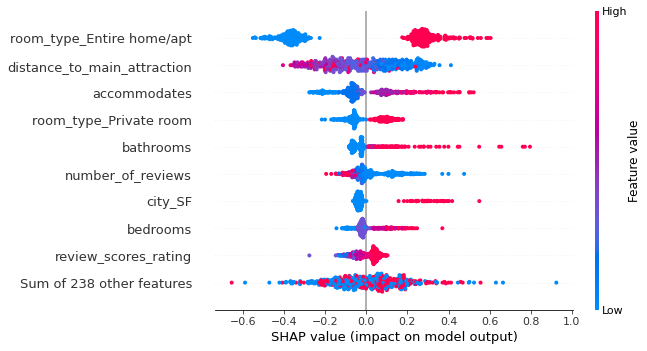

In [21]:
shap_sample = train_x.sample(500)
explainer = shap.Explainer(xgb_r.predict, shap_sample)
shap_values = explainer(shap_sample)
shap.plots.beeswarm(shap_values)

In [22]:
test_shap_values = explainer(test_x)

Permutation explainer: 14936it [25:20,  9.73it/s]                               


In [24]:
# define rel_res again with no abs to get over/under estimates
rel_res=residuals/test_y

In [25]:
rel_res.min()

-1.413643305412906

In [26]:
rel_res.max()

0.428316535065392

In [27]:
np.where(rel_res==-1.413643305412906)

(array([10541]),)

In [28]:
test_y[10541], prediction_test[10541]

(2.302585092994046, 5.557619)

In [29]:
np.where(rel_res==0.428316535065392)

(array([8733]),)

In [30]:
test_y[8733], prediction_test[8733]

(6.907755278982138, 3.9490495)

#### SHAP analysis of single most over estimated example

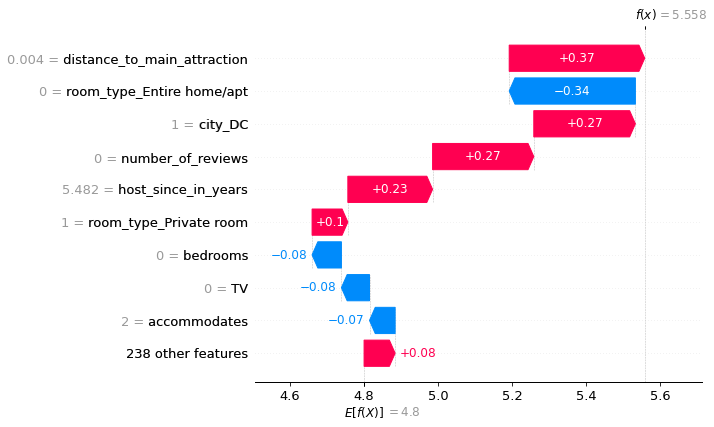

In [31]:
shap.plots.waterfall(test_shap_values[10541])

#### SHAP analysis of single most under estimated example

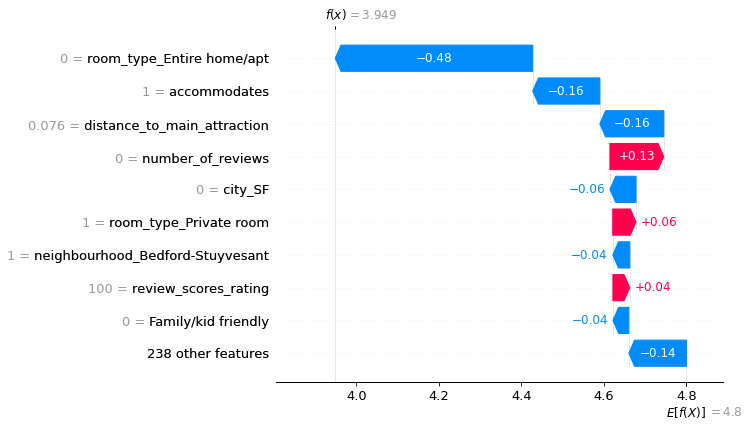

In [32]:
shap.plots.waterfall(test_shap_values[8733])

In [33]:
over_estimates = test_x.loc[np.where(rel_res<-0.05)]

#### SHAP analysis of all over estimated examples

Permutation explainer: 3747it [05:18, 11.29it/s]                                


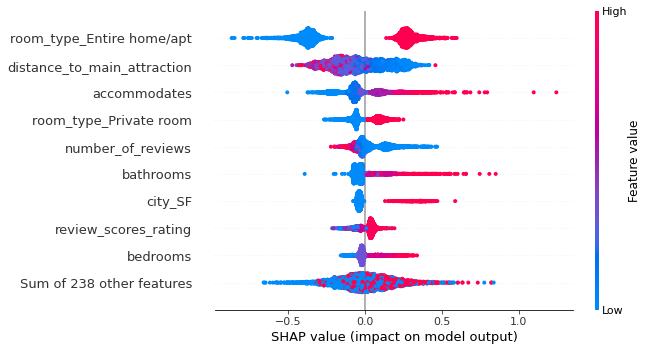

In [34]:
over_estimates_shap_values = explainer(over_estimates)
shap.plots.beeswarm(over_estimates_shap_values)

In [35]:
under_estimates = test_x.loc[np.where(rel_res>0.05)]

#### SHAP analysis of all under estimated examples

Permutation explainer: 3096it [04:25, 11.09it/s]                                


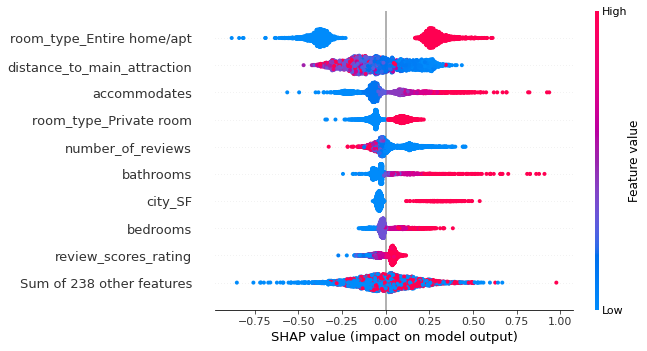

In [36]:
under_estimates_shap_values = explainer(under_estimates)
shap.plots.beeswarm(under_estimates_shap_values)

In [37]:
# apply abs on rel_res to get all good estimates
rel_res=abs(rel_res)
good_estimates = test_x.loc[np.where(rel_res<0.05)]

#### SHAP analysis of all good estimated examples

Permutation explainer: 8095it [12:06, 10.93it/s]                                


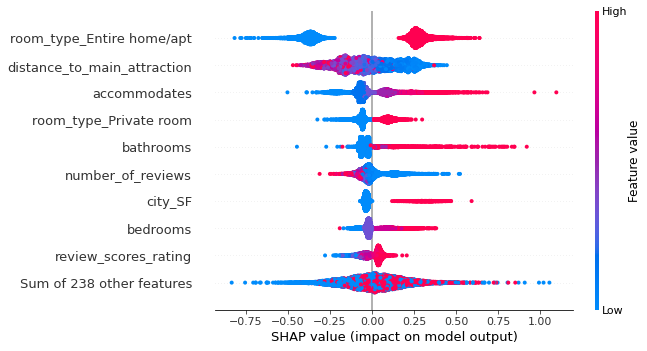

In [38]:
good_estimates_shap_values = explainer(good_estimates)
shap.plots.beeswarm(good_estimates_shap_values)

In [71]:
test_x.loc[10541]['distance_to_main_attraction']


0.0038820993632899575

In [72]:
np.where(data['distance_to_main_attraction'] == 0.0038820993632899575)

(array([51997]),)

In [77]:
data.iloc[51997]

id                                                                      10138870
log_price                                                               2.302585
property_type                                                          Apartment
room_type                                                           Private room
amenities                      {"Wireless Internet","Air conditioning",Kitche...
accommodates                                                                   2
bathrooms                                                                    1.0
bed_type                                                                Real Bed
cancellation_policy                                                     flexible
cleaning_fee                                                               False
city                                                                          DC
description                    Newly renovated, clean studio in the heart of ...
host_has_profile_pic        

In [78]:
test_x.loc[8733]['distance_to_main_attraction']

0.07584310932097094

In [79]:
np.where(data['distance_to_main_attraction'] == 0.07584310932097094)

(array([43228]),)

In [85]:
data.iloc[43228]

id                                                                      12089415
log_price                                                               6.907755
property_type                                                          Apartment
room_type                                                           Private room
amenities                      {TV,"Wireless Internet",Kitchen,"Smoking allow...
accommodates                                                                   1
bathrooms                                                                    1.5
bed_type                                                                Real Bed
cancellation_policy                                                     flexible
cleaning_fee                                                               False
city                                                                         NYC
description                    Hi I am a design student, and Im looking for s...
host_has_profile_pic        

In [84]:
data.iloc[43228]['description']

'Hi I am a design student, and Im looking for someone who would like to sublet my lovely and cozy room in Bed Stuy, Brooklyn. For the hole June, 2016. I live with three other cool and respectful roommates, right next to the G train (Bedford/Nostrand) G train and bike stations, nearby'

In [151]:
rel_res=residuals/test_y
rel_res_org = rel_res.copy()
rel_res.sort()
rel_res[-2]

0.4278806310501131

In [152]:
np.where(rel_res_org==0.4278806310501131)

(array([2418]),)

In [153]:
test_y[2418], prediction_test[2418]

(7.170119543449628, 4.1021643)

In [154]:
test_x.loc[2418]['distance_to_main_attraction']

0.10680069983670137

In [155]:
np.where(data['distance_to_main_attraction'] == 0.10680069983670137)

(array([11615]),)

In [156]:
data.iloc[11615]

id                                                                      17943415
log_price                                                                7.17012
property_type                                                              House
room_type                                                           Private room
amenities                      {"Cable TV","Wireless Internet","Air condition...
accommodates                                                                   1
bathrooms                                                                    1.0
bed_type                                                                Real Bed
cancellation_policy                                                     flexible
cleaning_fee                                                               False
city                                                                          DC
description                    We have a third floor room available with a sh...
host_has_profile_pic        

In [157]:
data.iloc[11615]['description']

'We have a third floor room available with a short term to long term rental agreement (3-12 months) in a newly built town home, located off East Capital and Benning Rd in Southeast, Washington DC.  We have a third floor room available with a short term to long term rental agreement (3-12 months) in a newly built town home, located off East Capital and Benning Rd in Southeast, Washington DC. We are conveniently located just a quick stroll from the Benning Rd metro station.  Inexpensive room (bed Included); includes sleek modern personal bathroom directly across the hall. Seeking an intern/student or working professional looking to live by a metro station. Tenant will have access to gourmet kitchen w/ SS appliances & granite counter tops, (SHARED) private fenced in back yards, and SHARED COMMON AREA. CLEANNESS IS A MUST. FEATURES:  - Wireless high speed Internet and Cable - Short distance to Benning Rd Metro - Brand new stainless steel kitchen appliances and washer / dryer. -Alarm System

In [175]:
len(data[data['log_price']>6.5])

1593

In [177]:
data[data['log_price']>7].iloc[12]['description']

'Huge - Luxurious Hollywood Mansion, over 5000 square feet, on your own private street and your own private hill right below the famous Hollywood Sign.  Only a 700 meter walk up to the sign.   5 Bedrooms each with their own private full bath.  Two bedrooms have in suite living rooms.   Luxurious living room with rap around bar.   Huge outdoor living area with 3 seating areas and views.   Large Dining Area, Family Room, views of Hollywood Hills and sign.    5 car parking plus plenty on street. Welcome to my huge, luxurious Hollywood mansion of over 5000 square feet located right below the Hollywood Sign, prime real estate in Hollywood.  My mansion has its own dedicated private street and private hill so we are in our own “bubble” so it’s very private.   There are viewsof the Hollywood sign (only 700 meters away) and Hollywood Hills from our balconies.  We allow quiet, respectful events at our mansion with our approval at our event rate (you can ask).  All 5 bedrooms are actually “suites

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

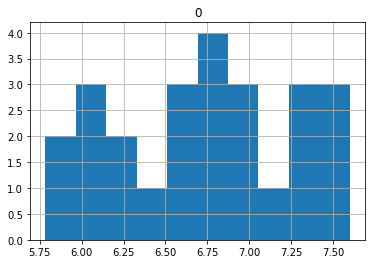

In [161]:
under_estimates_y_vals = test_y[np.where(rel_res_org>0.3)]
under_estimates_y_vals = pd.DataFrame(under_estimates_y_vals)
under_estimates_y_vals.hist()

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

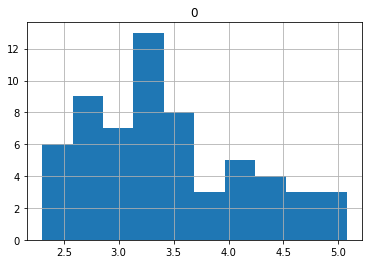

In [165]:
over_estimates_y_vals = test_y[np.where(rel_res_org<-0.3)]
over_estimates_y_vals = pd.DataFrame(over_estimates_y_vals)
over_estimates_y_vals.hist()

In [168]:
rel_res_org = abs(rel_res_org)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

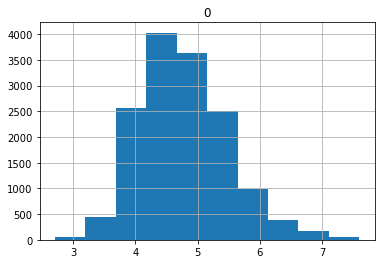

In [171]:
good_estimates_y_vals = test_y[np.where(rel_res_org<0.3)]
good_estimates_y_vals = pd.DataFrame(good_estimates_y_vals)
good_estimates_y_vals.hist()